Citamo za svaki od 13 centralnih proteina odgovarajuce lekove, izbacujemo one čiji je nivo značajnosti ispod 0.05, i takodje za svaki od njih uzimamo 20 najznačajnijih.

In [25]:
import pandas as pd
import os

directory_path = 'files/drugs/gene_drug'

signi_size = {}
total_size = {}
all_drugs = set() # svi lekovi za proteine
sign_genes_drugs_mapping = pd.DataFrame(columns=['Selection', 'Association Name'])
gene_most_sign_drugs = pd.DataFrame(columns=['Selection', 'Association Name'])

for filename in os.listdir(directory_path):  
    file_path = os.path.join(directory_path, filename)
    data = pd.read_csv(file_path, sep='\t')
    filtered_data = data[data['Significance'] < 0.05] # samo značajni 
    signi_size[data['Selection'][0]] = len(filtered_data)
    total_size[data['Selection'][0]] = len(data)
    all_drugs.update(filtered_data['Association Name'])
    sign_genes_drugs_mapping = pd.concat([sign_genes_drugs_mapping, filtered_data[['Selection', 'Association Name']]], ignore_index=True)
    most_significant = filtered_data.nsmallest(20, 'Significance') # izvlačimo 20 najznačajnijih
    gene_most_sign_drugs = pd.concat([gene_most_sign_drugs, most_significant[['Selection', 'Association Name']]], ignore_index=True)

In [2]:
print(signi_size)

{'CDKN2B': 170, 'POTEF': 128, 'ESR1': 889, 'FLNA': 109, 'CAV1': 563, 'CTNNB1': 397, 'CCND1': 984, 'MEN1': 137, 'EGFR': 1487, 'TP53': 1516, 'G6PD': 536, 'ACTB': 307, 'MAPK1': 690}


Čuvamo parove (Protein, Lek) u .sif formatu, iz kojeg ćemo kasnije u Cytoscape alatu prikazati mrežu.

In [3]:
#"{Naziv proteina}    -   {Naziv leka}" - oblik
with open('files/sign_drugs_genes_mapping.sif', 'w') as file:
    for index, row in sign_genes_drugs_mapping.iterrows():
        line = f"{row['Selection']}\t-\t{row['Association Name']}\n"
        file.write(line)

In [4]:
with open('files/gene_most_sign_drugs.sif', 'w') as file:
    for index, row in gene_most_sign_drugs.iterrows():
        line = f"{row['Selection']}\t-\t{row['Association Name']}\n"
        file.write(line)

In [3]:
len(all_drugs)

4683

In [4]:
len(sign_genes_drugs_mapping)

7913

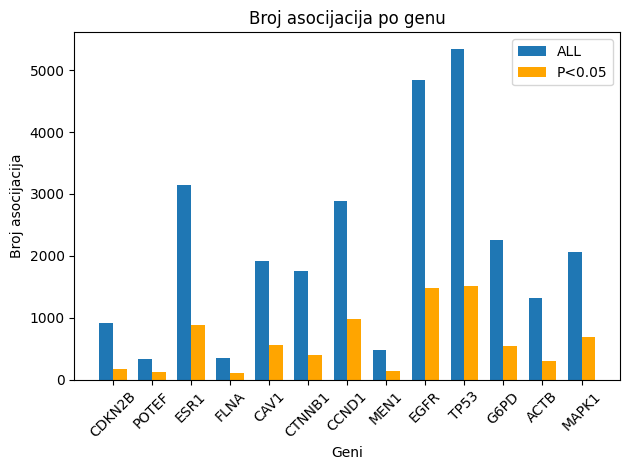

In [14]:
import numpy as np
import matplotlib.pyplot as plt

genes = list(total_size.keys())
all_counts = [total_size[gene] for gene in genes]
significant_counts = [signi_size[gene] for gene in genes]
bar_width = 0.35
ind = np.arange(len(genes))
fig, ax = plt.subplots()
all_bars = ax.bar(ind - bar_width/2, all_counts, bar_width, label='ALL')
signi_bars = ax.bar(ind + bar_width/2, significant_counts, bar_width, label='P<0.05', color='orange')

ax.set_title('Broj asocijacija po genu')
ax.set_xlabel('Geni')
ax.set_ylabel('Broj asocijacija')

ax.legend()

ax.set_xticks(ind)
ax.set_xticklabels(genes)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Čitamo lekove koji su vezani za odgovarajuće bolesti.

In [15]:
directory_path = 'files/drugs/disease_drug'
disease_map = {}

for filename in os.listdir(directory_path):  
    file_path = os.path.join(directory_path, filename)
    data = pd.read_csv(file_path, sep='\t')
    filtered_data = data[data['Significance'] < 0.05]
    disease_map[filename] = set(filtered_data['Association Name'])
    print(filename[0:-4] + " : " + str(len(filtered_data)))

PTA : 113
T2D : 1356
CVD : 1657


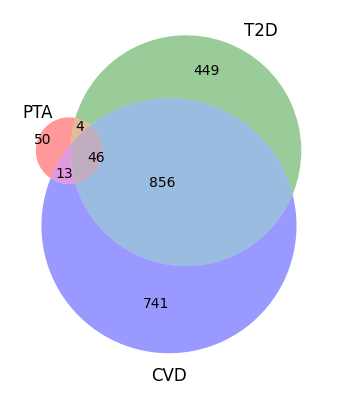

In [16]:
from matplotlib_venn import venn3
venn3([disease_map['PTA.txt'], disease_map['T2D.txt'], disease_map['CVD.txt']], ('PTA', 'T2D', 'CVD'))
plt.show()

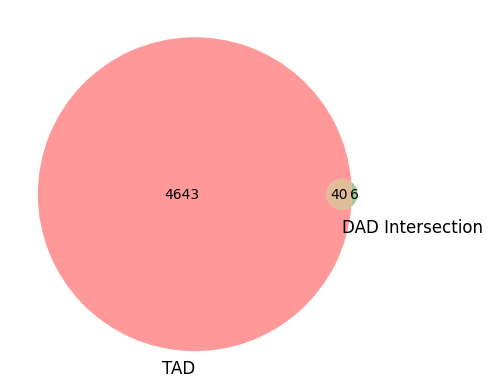

In [17]:
from matplotlib_venn import venn2
intersection = disease_map['PTA.txt'] & disease_map['T2D.txt'] & disease_map['CVD.txt'] 
venn2([all_drugs, intersection], ('TAD', 'DAD Intersection'))
plt.show()

Čuvamo sve ove skupove koji će nam biti ulaz u R skriptu koja pravi Veneove dijagrame sa četiri skupa.

In [10]:
def set_to_string(s):
    return '##'.join(map(str, sorted(s)))

with open('files/sets_data.txt', 'w') as file:
    file.write(set_to_string(disease_map['PTA.txt']) + '\n')
    file.write(set_to_string(disease_map['CVD.txt']) + '\n')
    file.write(set_to_string(disease_map['T2D.txt']) + '\n')
    file.write(set_to_string(all_drugs) + '\n')

Spisak od 40 proteina koji su u preseku TAD i DAD.

In [18]:
print(all_drugs & intersection)

{'Catechin', 'Ferrous Sulfate', 'Recombinant Parathyroid Hormone', 'Peptichemio', 'Lithium Carbonate', 'Heparin', 'Methylene Blue', 'Estradiol', 'Arginine/Omega-3 Fatty Acids/Nucleotides Oral Supplement', 'Octreotide', 'Nitric Oxide', 'Thyroglobulin', 'Menogaril', 'Cimetidine', 'Calcifediol', 'Recombinant Interleukin-6', 'Cisplatin', 'Carbon Monoxide', 'Adenosine Triphosphate', 'ERGOCALCIFEROL', 'Sargramostim', 'Fibroblast Growth Factor-23', 'Cholesterol', 'Recombinant Tumor Necrosis Factor Family Protein', 'Tyrosine', 'Charcoal', 'Cholecalciferol', 'Somatostatin', '25-hydroxyvitamin D', 'Polyethylene Glycols', 'Therapeutic Insulin', 'Thyrotropin-Releasing Hormone', 'Phosphates', 'Fluorodeoxyglucose F18', 'Technetium TC-99m', 'Nonsteroidal Antiinflammatory Drug', 'Therapeutic Corticosteroid', 'Paraffin', 'Glucose', 'Interferon-gamma'}
